# Import Stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import math
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
from recombinator import stationary_bootstrap
import scipy as sp
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.stattools import adfuller

from ovm.estimation.garch_estimation import estimate_garch_parameters

from ovm.historical.data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_scaling_factor, 
    compute_scaled_log_returns, 
    PriceHistory, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history
)

from ovm.paths import HISTORICAL_DATA_DIRECTORY
from ovm.time_resolution import TimeResolution

In [3]:
%matplotlib inline

# Set Parameters

If you want to estimate and simulate a different time scale, make changes here but keep in mind that you need to download the appropriate historical data first (see data import notebook).

In [4]:
time_resolution = TimeResolution.FIFTEEN_SECONDS
directory_path = os.path.join(HISTORICAL_DATA_DIRECTORY, time_resolution.value)
directory_path

'/home/michael/PycharmProjects/overlay-monetary/data/historical/15s'

In [5]:
price_history_file_name = 'ETH-USD'

# Load Price History

In [6]:
price_history = \
    load_price_history(filename=price_history_file_name, 
                       series_name=price_history_file_name, 
                       directory_path=directory_path, 
                       period_length_in_seconds=time_resolution.in_seconds)

In [7]:
path_length = len(price_history.price_history_df)

# Estimate GARCH Model

In [8]:
garch_estimation_result = estimate_garch_parameters(price_history)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 214398673.52729997
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1771834.7322120625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1771834.7315221645
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


In [9]:
garch_estimation_result.result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      ETH-USD   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.77183e+06
Distribution:      Standardized Student's t   AIC:                       3.54368e+06
Method:                  Maximum Likelihood   BIC:                       3.54374e+06
                                              No. Observations:              2515223
Date:                      Thu, Jan 21 2021   Df Residuals:                  2515218
Time:                              15:45:43   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.1350e-05  1.560e-04      0.457      0.647 [-2.344e-04,3.771e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.096e-04    158.204      0.000 [1.712e-02,1.755e-02]
alpha[1]       0.2000  9.204e-04    217.299      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.549e-04    912.373      0.000     [  0.778,  0.782]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0220  7.024e-03    572.605      0.000 [  4.008,  4.036]
========================================================================

Covariance estimator: robust
"""

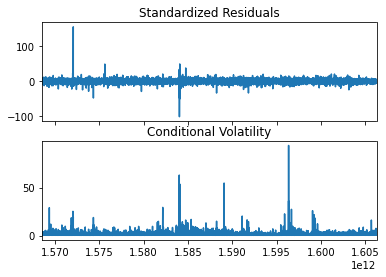

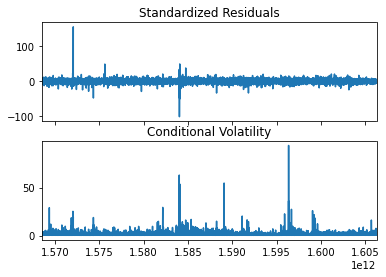

In [10]:
garch_estimation_result.result.plot()

# Simulate New Path Using GARCH

In [11]:
2# This is pretty slow. I intend to speed this up later on.
garch_simulation_result = \
    garch_estimation_result.simulate(path_length=path_length, 
                                     initial_discard_length=500)

In [12]:
garch_simulation_result.head()

0    0.000218
1    0.000328
2   -0.000016
3   -0.000384
4    0.000649
Name: data, dtype: float64

This is the simulated time series

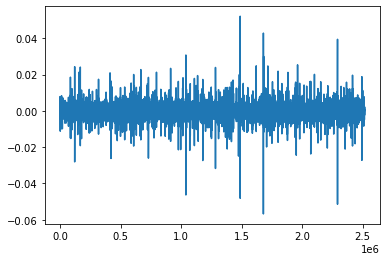

In [13]:
plt.plot(garch_simulation_result);

Note that the GARCH model succeeds at capturing average volatility during typical times but is unable to generate a few extreme returns.

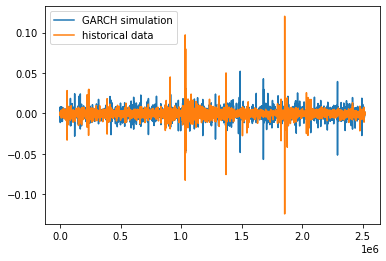

In [14]:
plt.plot(garch_simulation_result, label='GARCH simulation');
plt.plot(price_history.unscaled_log_returns.values, label='historical data');
plt.legend();

This model mis-specification arising from the T-distribution's inability to generate sufficiently heavy tails will be addressed by the non-parametric block-bootstrap.

This can be seen in the QQ-Plot (note the outliers at the extremes)

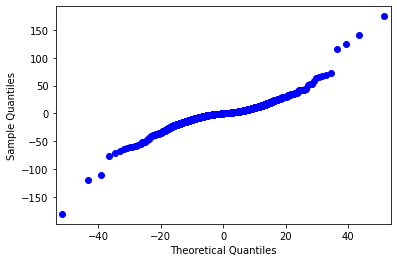

In [15]:
garch_estimation_result.qq_plot();

# Simulate New Path Using Block Bootstrap

Make the block size approximately 6 hours

In [16]:
# block_length = math.ceil(6 * 60 * 60 / time_resolution.in_seconds)
block_length = math.ceil(4 * 24 * 60 * 60 / time_resolution.in_seconds)
# block_length

In [17]:
bootstrap_simulation_result = \
    stationary_bootstrap(x=price_history.unscaled_log_returns, 
                         block_length=block_length, 
                         replications=1).squeeze()

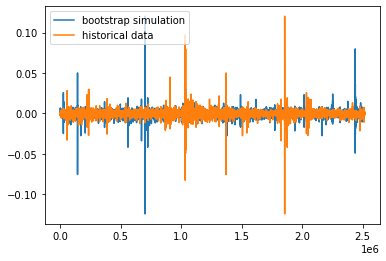

In [18]:
plt.plot(bootstrap_simulation_result, label='bootstrap simulation');
plt.plot(price_history.unscaled_log_returns.values, label='historical data');
plt.legend(loc=2);

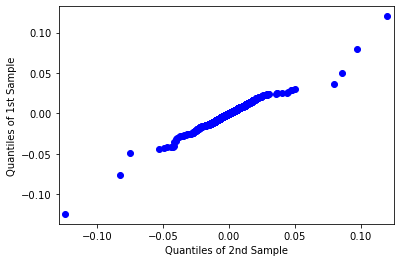

In [19]:
qqplot_2samples(bootstrap_simulation_result, price_history.unscaled_log_returns.values);

Estimate GARCH model with t-distributed errors from boostrap

In [20]:
garch_11_t = \
    arch.arch_model(compute_scaled_log_returns(bootstrap_simulation_result, 
                                               period_length_in_seconds=time_resolution.in_seconds), 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='StudentsT'
                   )
garch_11_t_fitted = garch_11_t.fit()
garch_11_t_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1457419.296570614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1457419.2958440005
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.45742e+06
Distribution:      Standardized Student's t   AIC:                       2.91485e+06
Method:                  Maximum Likelihood   BIC:                       2.91491e+06
                                              No. Observations:              2515223
Date:                      Thu, Jan 21 2021   Df Residuals:                  2515218
Time:                              15:46:13   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.7331e-04  1.361e-04      7.150  8.657e-13 [7.065e-04,1.240e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0127  7.820e-05    161.831      0.000 [1.250e-02,1.281e-02]
alpha[1]       0.2000  1.143e-03    175.045      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.860e-04    880.348      0.000     [  0.778,  0.782]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.2378  6.411e-03    660.974      0.000 [  4.225,  4.250]
========================================================================

Covariance estimator: robust
"""

The GARCH volatility and distribution coefficients are close to those estimated from the original time series.